In [201]:
import numpy as np
import pandas as pd
import cv2 as cv
import matplotlib.pyplot as plt

In [202]:
class Perceptron:
    def __init__(self,eta=0.01,n_iter=50,threshold=0):
        self.eta = eta
        self.n_iter = n_iter
        self.threshold = threshold
        
    def fit(self, X, y):
        self.w_ = np.zeros(1 + X.shape[1])
        for i in range(self.n_iter):
            for Xi,target in zip(X,y):
                update = self.eta*(target - self.calc_ans(Xi))
                self.w_[1:] += update*Xi
                self.w_[0] += update
                
    def net_input(self, X):
        return np.dot(X,self.w_[1:])+self.w_[0]
    
    def calc_ans(self, x):
        if self.net_input(x)>=self.threshold:
            return 1
        else:
            return 0

    def predict(self, X):
        predict = []
        prob = []
        for idx in range(len(X)):  
            prob.append(self.net_input(X[idx]))
            predict.append(self.calc_ans(X[idx]))
            
        return np.array(prob),np.array(predict)

In [203]:
def accuracy(true,pred):
    return np.sum(true==pred)/len(true)

In [204]:
def confusion_mat(true,pred):
    K = len(np.unique(true)) # Number of classes 
    result = np.zeros((K, K))

    for i in range(len(true)):
        result[true[i]][pred[i]] += 1

    return result

In [205]:
import matplotlib.pyplot as plt
def ROC_plot(fpr,tpr):
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve')
    plt.legend(loc="lower right")
    plt.show()

In [206]:
def predict_result(score,threshold):
    pred = np.zeros([score.shape[0]]).astype(np.int)
    pred[score>threshold] = 1
    return pred

In [207]:
def ROC(label,score):
    threshold = np.max(score)+1
    desc_score_indices = np.sort(score, kind="mergesort")[::-1]
    
    fpr_collect = []
    tpr_collect = []
    threshold_collect = []
    for i in range(len(desc_score_indices)): 
        pred = predict_result(score,threshold)
        matrix = confusion_mat(label,pred)

        tn = matrix[0][0]
        fp = matrix[0][1]
        fn = matrix[1][0]
        tp = matrix[1][1]

        fpr = fp/(fp+tn)
        tpr = tp/(tp+fn)
        
        fpr_collect.append(fpr)
        tpr_collect.append(tpr)
        threshold_collect.append(threshold)
        
        threshold = desc_score_indices[i]
    
    return np.array(fpr_collect),np.array(tpr_collect),threshold_collect

In [208]:
def AUC(x,y):
    return np.trapz(y, x)

In [209]:
img = []
label = [] #0 for male 1 for female

# Male
bmp = cv.imread('mP1.bmp',0)
for x in range(0,400,40):
    for y in range(0,400,40):
        img.append(bmp[x:x+40,y:y+40])
        label.append(0)
# flip
for x in range(0,400,40):
    for y in range(0,400,40):
        img.append(np.flip(bmp[x:x+40,y:y+40],axis=1))
        label.append(0)
        
# Female
bmp = cv.imread('fP1.bmp',0)
for x in range(0,400,40):
    for y in range(0,400,40):
        img.append(bmp[x:x+40,y:y+40]) 
        label.append(1)
# flip
for x in range(0,400,40):
    for y in range(0,400,40):
        img.append(np.flip(bmp[x:x+40,y:y+40],axis=1))
        label.append(1)
        
img = np.array(img)
img = img.reshape(img.shape[0],img.shape[1]*img.shape[2])
label = np.array(label)

In [210]:
print(img.shape)
print(label.shape)

(400, 1600)
(400,)


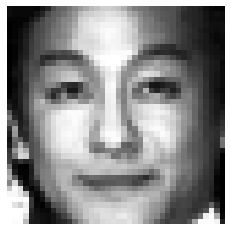

In [211]:
plt.imshow(img[0].reshape(40,40),cmap='gray')
plt.axis('off')
plt.show()

In [212]:
class PCA:
    def __init__(self):
        return
    def fit(self,feature, component=2):
        feature_num = feature.shape[1]
        
        eig_vecs, eig_vals, V = np.linalg.svd(feature.T)
        self.eig_pairs = [(np.abs(eig_vals[i]), eig_vecs[:,i]) for i in range(len(eig_vals))]
        
        self.component = np.hstack((self.eig_pairs[0][1].reshape(feature_num,1), 
                          self.eig_pairs[1][1].reshape(feature_num,1)))
        
        for i in range(2,component):
            self.component = np.hstack((self.component, self.eig_pairs[i][1].reshape(feature_num,1)))
        
    def transform(self,feature):
        return feature@self.component
    
    def inverse_transform(self,feature):
        return feature@self.component.T
    
    def get_componet(self):
        return self.component
    
    def get_eignepair(self):
        return self.eig_pairs

In [213]:
np.random.seed(5)
msk = np.random.rand(len(img)) < 0.9
test_X = img[~msk]
test_Y = label[~msk]

train_X = img[msk]
train_Y = label[msk]
train_X.shape

(359, 1600)

Linear Classifier/traning
Accuracy: 1.0
Confusion Matrix:
[[177.   0.]
 [  0. 182.]]
AUC: 0.9887005649717514


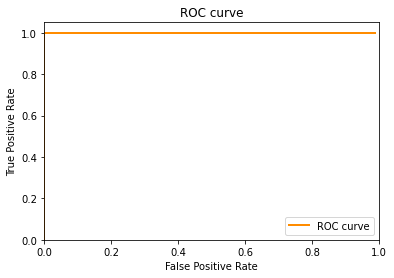

In [214]:
#Raw data perceptron
linear_classifier = Perceptron(n_iter=1000)
linear_classifier.fit(train_X,train_Y)

prob,pred = linear_classifier.predict(train_X)
print("Linear Classifier/traning")
print("Accuracy:",accuracy(train_Y, pred))
print("Confusion Matrix:")
print(confusion_mat(train_Y, pred))
fpr, tpr, thresholds =  ROC(train_Y,prob)
print("AUC:",AUC(fpr,tpr))
ROC_plot(fpr,tpr)

Linear Classifier/testing
Accuracy: 0.9024390243902439
Confusion Matrix:
[[20.  3.]
 [ 1. 17.]]
AUC: 0.8913043478260868


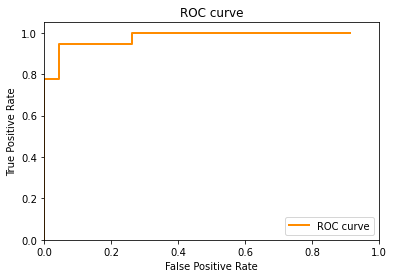

In [215]:
prob,pred = linear_classifier.predict(test_X)
print("Linear Classifier/testing")
print("Accuracy:",accuracy(test_Y, pred))
print("Confusion Matrix:")
print(confusion_mat(test_Y, pred))
fpr, tpr, thresholds =  ROC(test_Y,prob)
print("AUC:",AUC(fpr,tpr))
ROC_plot(fpr,tpr)

In [216]:
# standardization data
def standardize(data):
    mean = data.mean(axis=0)
    out = data - mean
    out /= np.std(out)
    return out

In [217]:
train_X = standardize(train_X)
test_X = standardize(test_X)

In [218]:
pca = PCA()
pca.fit(train_X, component=191)
component = pca.get_componet()
eigen_pair = pca.get_eignepair()

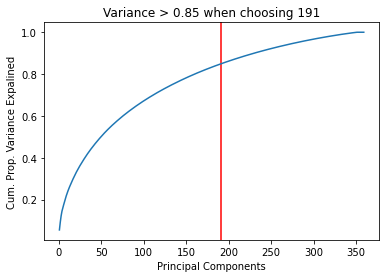

In [219]:
var_comp_sum = np.cumsum(np.array(eigen_pair)[:,0])/sum(np.array(eigen_pair)[:,0])
num_comp = range(1,len(eigen_pair)+1)
result = np.where(var_comp_sum >= 0.85)

plt.title('Variance > 0.85 when choosing {}'.format(result[0][0]))
plt.xlabel('Principal Components')
plt.ylabel('Cum. Prop. Variance Expalined')
plt.axvline(x=result[0][0], color='r', linestyle='-')
plt.plot(num_comp, var_comp_sum)
plt.show()

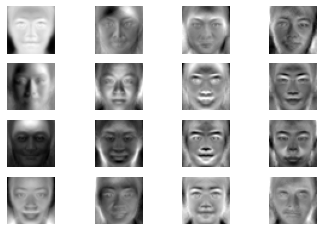

In [220]:
f,ax = plt.subplots(4,4)
for i in range(4):
    for j in range(4):
        ax[i][j].imshow(component.T[i+j*4].reshape(40,40),cmap='gray')
        ax[i][j].axis('off')
plt.show()

In [221]:
train_X_PCA = pca.transform(train_X)
test_X_PCA = pca.transform(test_X)

Linear Classifier/training
Accuracy: 1.0
Confusion Matrix:
[[23.  0.]
 [18.  0.]]
AUC: 0.9887005649717514


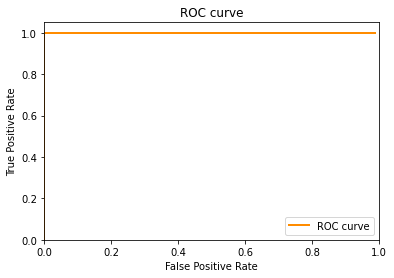

In [222]:
#Raw data perceptron
linear_classifier = Perceptron(n_iter=100)
linear_classifier.fit(train_X_PCA,train_Y)

prob,pred = linear_classifier.predict(train_X_PCA)
print("Linear Classifier/training")
print("Accuracy:",accuracy(train_Y, pred))
print("Confusion Matrix:")
print(confusion_mat(test_Y, pred))
fpr, tpr, thresholds =  ROC(train_Y,prob)
print("AUC:",AUC(fpr,tpr))
ROC_plot(fpr,tpr)

Linear Classifier/testing
Accuracy: 0.926829268292683
Confusion Matrix:
[[21.  2.]
 [ 1. 17.]]
AUC: 0.9009661835748791


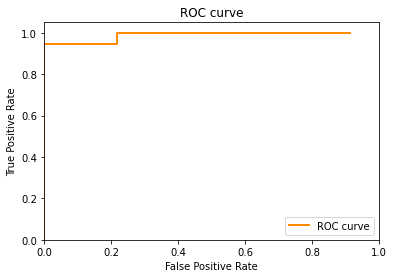

In [223]:
prob,pred = linear_classifier.predict(test_X_PCA)
print("Linear Classifier/testing")
print("Accuracy:",accuracy(test_Y, pred))
print("Confusion Matrix:")
print(confusion_mat(test_Y, pred))
fpr, tpr, thresholds =  ROC(test_Y,prob)
print("AUC:",AUC(fpr,tpr))
ROC_plot(fpr,tpr)

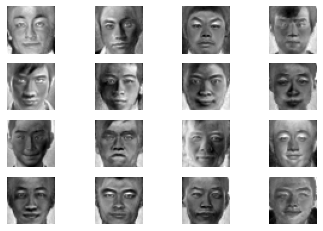

In [224]:
f,ax = plt.subplots(4,4)
for i in range(4):
    for j in range(4):
        ax[i][j].imshow(pca.inverse_transform(train_X_PCA[i+j*4]).reshape(40,40),cmap='gray')
        ax[i][j].axis('off')
plt.show()

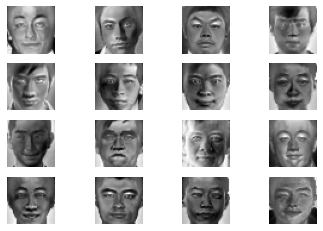

In [225]:
f,ax = plt.subplots(4,4)
for i in range(4):
    for j in range(4):
        ax[i][j].imshow(train_X[i+j*4].reshape(40,40),cmap='gray')
        ax[i][j].axis('off')
plt.show()